# Travel insurance claim prediction and analysis
* Chi Phuong Dao
* I Putu Agastya Harta Pratama

Faculty of Economic Sciences <br>
University of Warsaw <br>
Warsaw, Poland <br>
2025

### Library and data import

In [73]:
from imblearn.over_sampling import RandomOverSampler
!pip install pandas numpy scikit-learn seaborn statsmodels matplotlib xgboost lightgbm mlxtend imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imblearn]1/3 [imbalanced-learn]


In [85]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import mannwhitneyu, pointbiserialr, chi2_contingency, spearmanr

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2 as chi2_stat
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.svm import SVC
from sklearn.metrics import (balanced_accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             classification_report)
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier

In [3]:
train = pd.read_csv('insurance_train.csv')

In [4]:
test = pd.read_csv('insurance_test.csv')

# I. Exploratory Data Analysis

## 1. Data overview

In [5]:
train.head()

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
0,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.284509,50b3e71e,51,united states,105.459587,SecurePlan Flex,21
1,18.428627,0,9b2d5b46,type_a,web,0,agt_0001,0.207538,96d6c6df,32,spain,30.433459,DriveSafe Rental Addon,6
2,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.300461,50b3e71e,38,new zealand,78.728474,TripGuard Cancel,84
3,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.132404,50b3e71e,30,thailand,17.146843,TripGuard Cancel,39
4,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.070443,50b3e71e,37,viet nam,10.476416,TripGuard Cancel,48


In [6]:
train.describe()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length
count,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000
mean,9.794976,0.014633,1.093941,0.189540,39.697261,40.750070,49.234888
std,19.791119,0.120081,0.923113,0.080641,12.603433,48.749221,98.659469
min,0.000000,0.000000,0.000000,0.000000,18.000000,-406.642669,1.000000
25%,0.000000,0.000000,0.000000,0.136389,34.000000,18.246389,9.000000
50%,0.000000,0.000000,1.000000,0.181041,36.000000,26.785242,22.000000
75%,11.336612,0.000000,2.000000,0.230836,44.000000,47.809948,53.000000
max,282.073580,1.000000,6.000000,1.000000,100.000000,801.049866,4856.000000


In [7]:
train.dtypes

reward                  float64
claim_status              int64
person_gender            object
entity_type              object
channel                  object
support_interactions      int64
agent_id                 object
customer_score          float64
entity_a                 object
person_age                int64
location                 object
revenue                 float64
product_id               object
trip_length               int64
dtype: object

In [8]:
train.isnull().sum()

reward                  0
claim_status            0
person_gender           0
entity_type             0
channel                 0
support_interactions    0
agent_id                0
customer_score          0
entity_a                0
person_age              0
location                0
revenue                 0
product_id              0
trip_length             0
dtype: int64

In [9]:
test.isnull().sum()

reward                  0
person_gender           0
entity_type             0
channel                 0
support_interactions    0
agent_id                0
customer_score          0
entity_a                0
person_age              0
location                0
revenue                 0
product_id              0
trip_length             0
dtype: int64

There is no missing value for both the training and testing dataset 

In [10]:
train.nunique()

reward                  25246
claim_status                2
person_gender               3
entity_type                 2
channel                     2
support_interactions        7
agent_id                   16
customer_score          56862
entity_a                   16
person_age                 74
location                  146
revenue                 55300
product_id                 26
trip_length               448
dtype: int64

In [68]:
claim_counts = train['claim_status'].value_counts().sort_index()
claim_pct    = (claim_counts / len(train) * 100)
claim_df = (pd.DataFrame({'count': claim_counts, 'percentage_%': claim_pct})
      .rename_axis("claim_status"))
display(claim_df)                    

,count,percentage_%
claim_status,,
0,56159,98.536662
1,834,1.463338


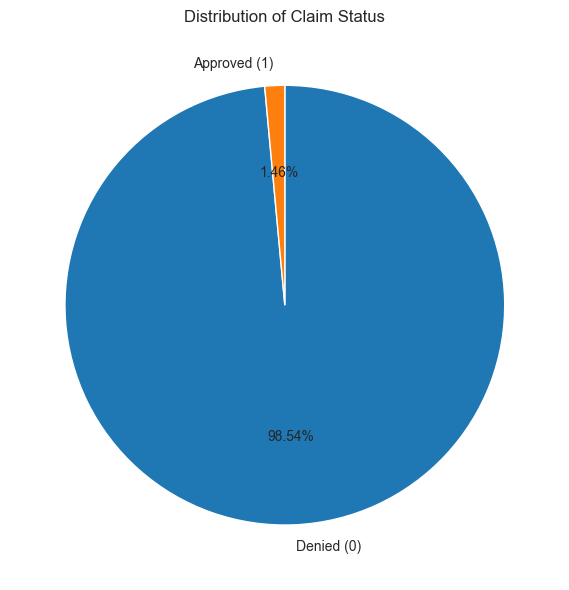

In [71]:
plt.figure(figsize=(6, 6))
plt.pie(claim_counts, labels=['Denied (0)', 'Approved (1)'], autopct='%1.2f%%', startangle=90, counterclock=False)
plt.title("Distribution of Claim Status")
plt.tight_layout()
plt.show()

In general, almost insurance claims got rejected, so there is extreme class imbalance with fewer than 2% of them got accepted. Therefore, a naive model that always predicts "0" would already score 98.5% accuracy while doing nothing useful. Hence, for this dataset, the accuracy is a misleading metric, we will focus on the recall/precision, ROC-AUC instead. 

In [12]:
train.duplicated().sum()

np.int64(0)

No duplicate value is found in this dataset. 

In [13]:
train.describe()

,reward,claim_status,support_interactions,customer_score,person_age,revenue,trip_length
count,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000,56993.000000
mean,9.794976,0.014633,1.093941,0.189540,39.697261,40.750070,49.234888
std,19.791119,0.120081,0.923113,0.080641,12.603433,48.749221,98.659469
min,0.000000,0.000000,0.000000,0.000000,18.000000,-406.642669,1.000000
25%,0.000000,0.000000,0.000000,0.136389,34.000000,18.246389,9.000000
50%,0.000000,0.000000,1.000000,0.181041,36.000000,26.785242,22.000000
75%,11.336612,0.000000,2.000000,0.230836,44.000000,47.809948,53.000000
max,282.073580,1.000000,6.000000,1.000000,100.000000,801.049866,4856.000000


For most of the variables, it stays within range. Reward, revenue are slightly skewed with right tail. The trip length is noticeable right-skew, the 75% percentile is 53 days, but the maximum length is over 13 years, it is worth to inspect these values. 

In [14]:
train['agent_id'] = train['agent_id'].str[-2:].astype(int)
test['agent_id'] = test['agent_id'].str[-2:].astype(int)

In [15]:
#distribution of numerical variable
target = "claim_status"
approved   = train[train[target] == 1]
not_approved = train[train[target] == 0]
numeric_cols = train.select_dtypes(include=["int64", "float64"]).columns.drop(target)

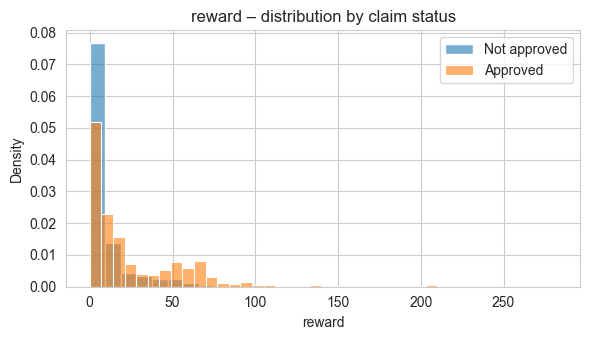

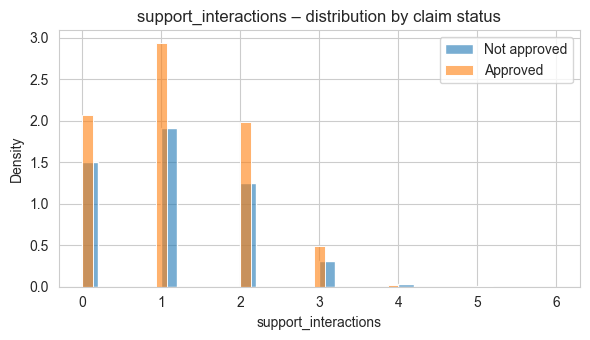

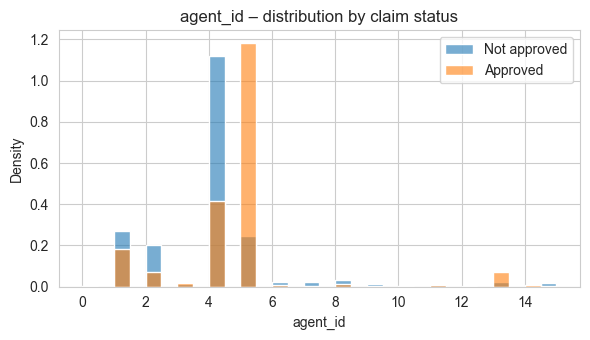

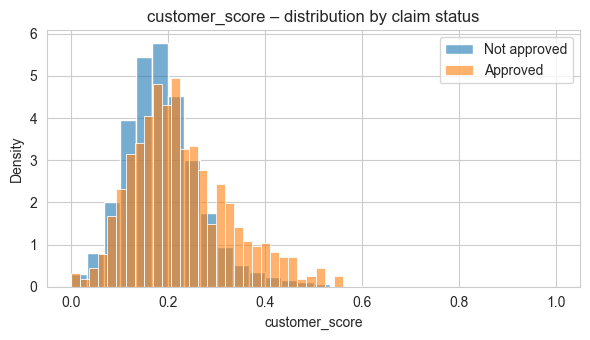

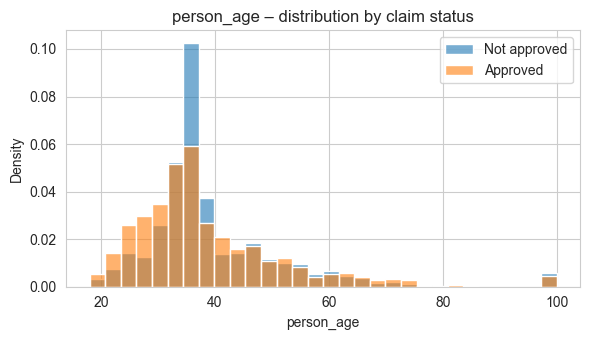

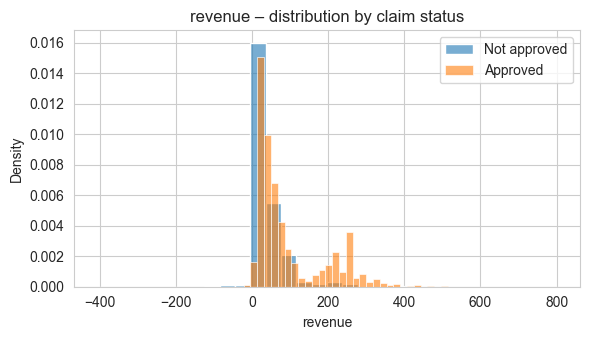

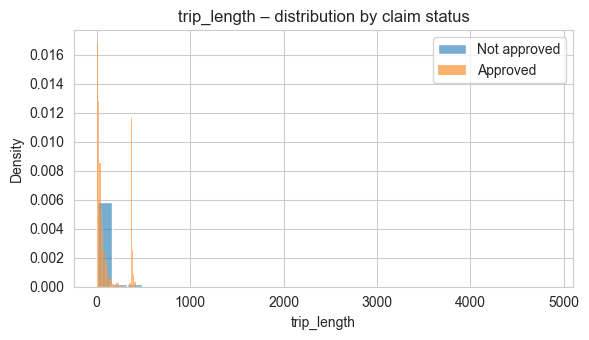

In [16]:
for col in numeric_cols:
    plt.figure(figsize=(6,3.5))
    sns.histplot(not_approved[col], color="tab:blue", label="Not approved", kde=False,
                 bins=30, stat="density", alpha=0.6)
    sns.histplot(approved[col],     color="tab:orange", label="Approved",    kde=False,
                 bins=30, stat="density", alpha=0.6)
    plt.title(f"{col} – distribution by claim status")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

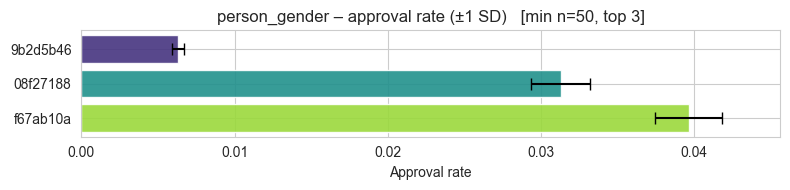

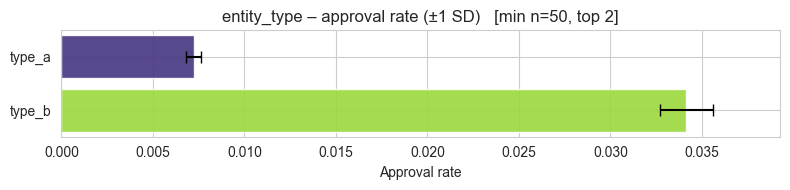

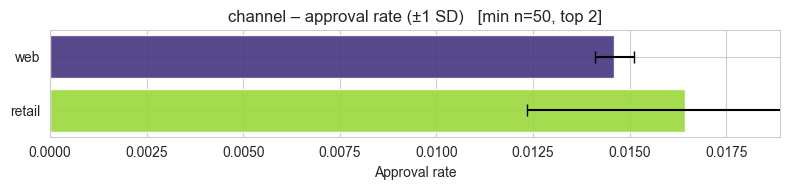

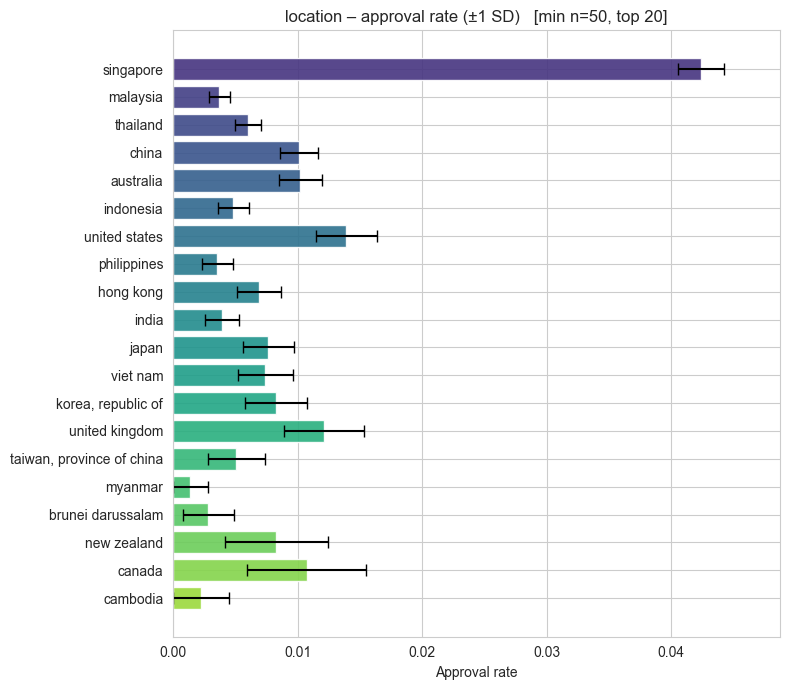

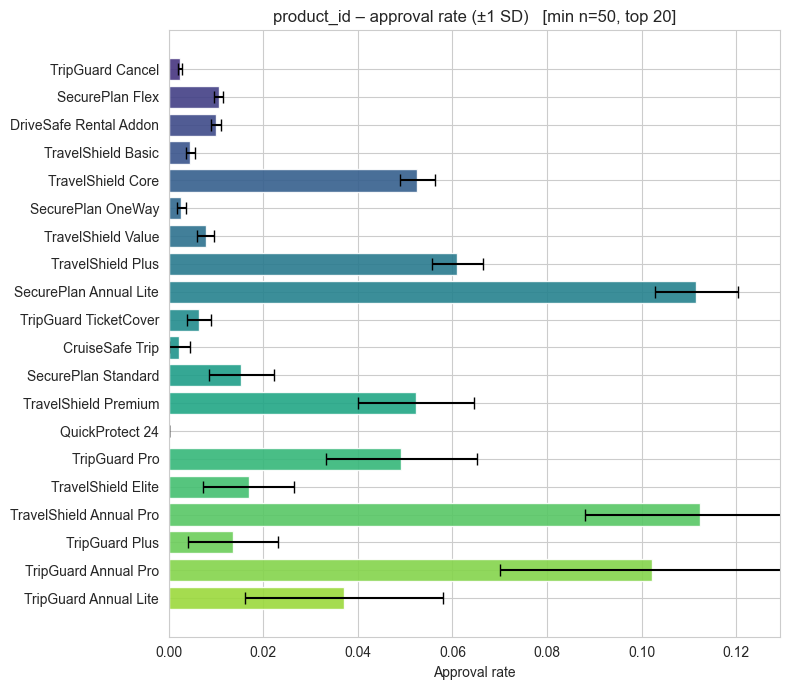

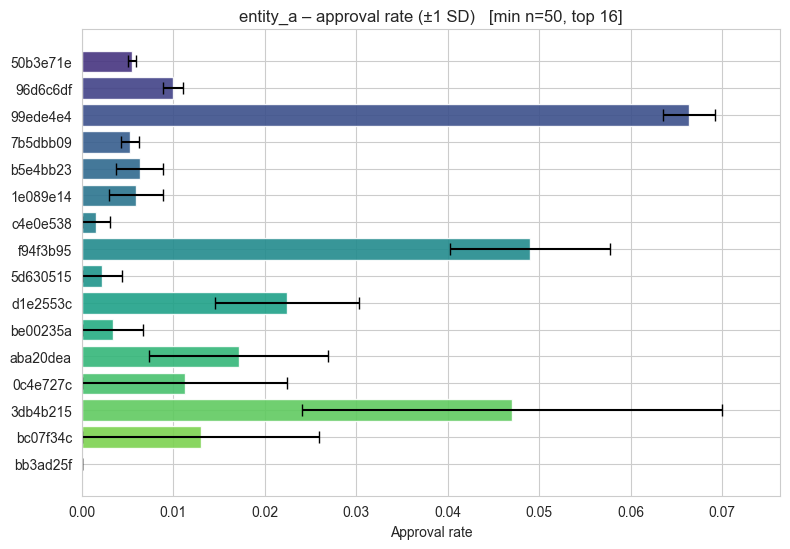

In [17]:
def plot_approval_rate(train, cat_cols, target="claim_status",
                       min_count=50,         
                       top_k=25,              
                       palette="viridis"):    

    cross = pd.crosstab(train[cat_cols], train[target])
    n_total = cross.sum(axis=1)
    cross = cross[n_total >= min_count]                 
    if cross.empty:
        print(f"[{cat_cols}] – nothing meets min_count={min_count}")
        return

    p = cross[1] / cross.sum(axis=1)
    std = np.sqrt(p * (1 - p) / cross.sum(axis=1))

    order = cross.sum(axis=1).sort_values(ascending=False).head(top_k).index
    p, std = p.loc[order], std.loc[order]

    n_bars = len(order)
    fig_h = max(2, 0.35 * n_bars)                       
    cmap  = plt.get_cmap(palette)
    colors = cmap(np.linspace(0.15, 0.85, n_bars))

    fig, ax = plt.subplots(figsize=(8, fig_h))
    ax.barh(y=order, width=p, xerr=std,
            color=colors, alpha=0.9, capsize=4)
    ax.set_xlabel("Approval rate")
    ax.set_title(f"{cat_cols} – approval rate (±1 SD)   "
                 f"[min n={min_count}, top {n_bars}]")
    ax.set_xlim(0, p.max() * 1.15)
    ax.invert_yaxis()                             
    plt.tight_layout()
    plt.show()

categoricals = ["person_gender", "entity_type", "channel",
                "location", "product_id", "entity_a"]

for col in categoricals:
    plot_approval_rate(train, col,
                       min_count=50,   
                       top_k=20)        

These plots act as visualization dashboard to figure out which feature are important to the claim status. For numerical values, we use histogram overlapping plot to see the distribution and horizontal barplots for categorical features. <br>
We found these following information from studying the individual features:
- **Age**: The median age in both group are identical, approvals mildly concentrated in working-age (26-45); older groups approve less but cohort is small.
- **Customer score & Reward**: Customer score does have a positive correlation with the claim approval, however, having higher reward does not guarantee approval 
- **Discount Flag**: negative revenue (i.e., heavily discounted sales) rarely see claim approvals.
- **Location**: The majority of approval case are based in Singapore, this could indicate that the insurance company is located in Singapore, or the majority of their client are from Singapore. Followed by United States, Canada and United Kingdom. Those are expensive destination which might require more expensive insurance package that has better protection -> higher positive claim approval
- **Agent**: For certain agents, there is higher chance of claim getting approve compare to other, especially for agent 5. 
- **Identity**: Agency B has much higher approval rate, reflects the policy differences between these two. 
- **Gender**: The gender in this dataset might be masked from the real value of Male, Female, Unknown, but they are valuable features and can be encoded to use as part of the classification.
- **Product**: Annual insurance product received the highest claim approval, including TravelShield Annual Pro, SecurePlan Annual Lite, Tripguard Annual Pro
- **Revenue**: The probability of a claim with higher revenue get accepted is much  higher than those that generates lower revenue. 


## 2. Data analysis

We wonder if there is any interaction between features, are there some certain features that can combine for the better chance of claim approval? Maybe the customer score dependent claim approval change with different entity types? Or maybe age is a factor that influence the revenue amount that lead to different claim result? We are trying to make some relevant guesses to figure the relations of features. 

Before getting into details of every single one, we will plot an overview by create a correlation matrix for each numerical variable with all other numerical variables. 

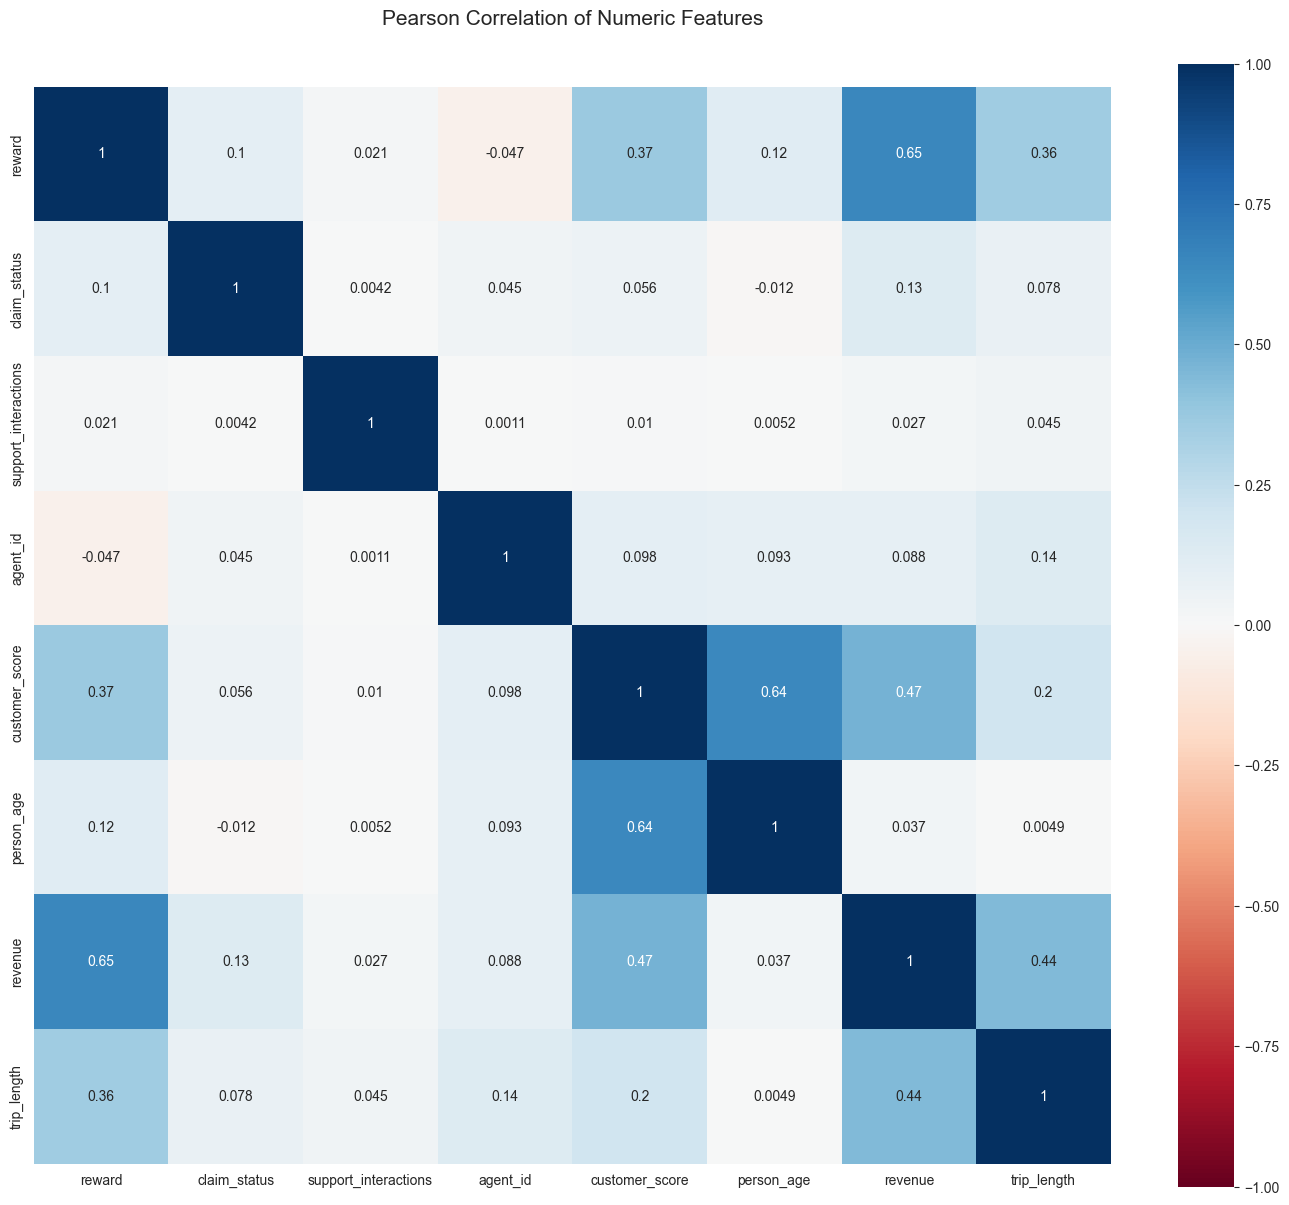

In [18]:
#corr = train.select_dtypes('number').corr()
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Numeric Features", 
          y=1.05, size=15)

sns.heatmap(train.select_dtypes('number').corr(),       
    vmin=-1,vmax=1.0, square=True, cmap = plt.cm.RdBu, linecolor='white', annot=True)

plt.tight_layout()
plt.show()

We learned that:
- Reward, revenue, customer score and trip length is slightly positive correlated with claim status, which means the higher the features value get, the higher chance their claims got accepted. 
- On the other hand, customer age is negatively correlate with claim status, so younger person has more chance to get approved claim compare to older person. 

#### Long trip insurance plans

In [19]:
over_365 = (train['trip_length'] > 365).sum()
total   = len(train)
print(f"Rows with trip_length > 365 days: {over_365} / {total} ({over_365/total:.2%})")

Rows with trip_length > 365 days: 1309 / 56993 (2.30%)


In [20]:
over365 = train[train['trip_length'] > 365]
over365

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
45,66.599115,0,08f27188,type_b,web,3,5,0.536950,99ede4e4,80,singapore,271.365503,SecurePlan Annual Lite,366
84,0.000000,0,f67ab10a,type_a,retail,1,14,0.382903,3db4b215,66,singapore,97.793344,SecurePlan Individual,373
115,63.547746,0,f67ab10a,type_b,web,0,5,0.407590,99ede4e4,54,singapore,249.399131,SecurePlan Annual Lite,372
328,52.944557,0,08f27188,type_b,web,2,5,0.352493,99ede4e4,45,singapore,217.673313,SecurePlan Annual Lite,367
382,148.737604,0,f67ab10a,type_a,web,0,13,0.300848,f94f3b95,33,united states,219.755066,TripGuard Annual Lite,368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56907,173.027949,0,08f27188,type_a,web,2,13,0.277256,f94f3b95,24,united states,254.129396,TripGuard Annual Pro,373
56910,39.837656,0,08f27188,type_b,web,2,5,0.323257,99ede4e4,30,singapore,169.046803,SecurePlan Annual Lite,366
56936,62.440537,0,f67ab10a,type_b,web,1,5,0.227380,99ede4e4,32,singapore,265.545708,SecurePlan Annual Lite,382
56939,56.047887,0,08f27188,type_b,web,0,5,0.326339,99ede4e4,33,singapore,208.463196,SecurePlan Annual Lite,368


In [21]:
print("\nProducts use for long trip:")
print(over365['product_id'].value_counts().head(10))


Products use for long trip:
product_id
SecurePlan Annual Lite     937
TravelShield Annual Pro    120
TripGuard Annual Pro        76
TripGuard Annual Lite       66
TripGuard Annual Max        40
SecurePlan Individual       38
SecurePlan Family           11
TripGuard TicketCover       11
SecurePlan Junior            5
TravelShield Core            4
Name: count, dtype: int64


In [22]:
print("\nApproval rates by product:")
print(pd.crosstab(over365['product_id'], over365['claim_status'], normalize='index')[1].sort_values(ascending=False).head(10))


Approval rates by product:
product_id
TravelShield Annual Pro    0.116667
SecurePlan Annual Lite     0.106724
TripGuard Annual Pro       0.105263
SecurePlan Family          0.090909
TripGuard Annual Max       0.075000
TripGuard Annual Lite      0.030303
DriveSafe Rental Addon     0.000000
SecurePlan Individual      0.000000
SecurePlan Junior          0.000000
TravelShield Core          0.000000
Name: 1, dtype: float64


In [23]:
print("\nEntity type approval:")
print(pd.crosstab(over365['entity_type'], over365['claim_status'],normalize='index')[1])


Entity type approval:
entity_type
type_a    0.059072
type_b    0.106343
Name: 1, dtype: float64


In [24]:
print("\nTop agents sell long trip insurance:")
print(over365['agent_id'].value_counts().head(10))


Top agents sell long trip insurance:
agent_id
5     1061
13     182
14      54
8       11
1        1
Name: count, dtype: int64


In [25]:
print("\nTop locations for long term plans:")
print(over365['location'].value_counts().head(10))


Top locations for long term plans:
location
singapore        1115
united states     136
china              40
australia           8
indonesia           6
hong kong           2
sweden              1
malaysia            1
Name: count, dtype: int64


***2.3% of all insurances*** (1 309/56 993) last **longer than one year**, and they are overwhelmingly sold ***in Singapore*** (1 115 cases, ∼85 % of annuals), followed by the U.S. (136), China (40) and other markets.  Out of all agents, ***agent 5*** (1 061 annuals), **agent 13** (182), **agent 14** (54) are handling nearly all these long-haul plans.  Underwriting varies by channel: type_b approves these annual contracts at roughly 10.6 % versus 5.9 % for type_a.  

Product-level risk is also interesting: ***TravelShield Annual Pro*** tops at 11.7 % approval, then ***SecurePlan Annual Lite*** (10.7 %), ***TripGuard Annual Pro*** (10.5 %), and SecurePlan Family (9.1 %), while other “Annual” offerings cluster below 7 %.  Together, this tells us that annual-plan policies form a distinct, high-approval cohort—sold predominantly by a few agents in Singapore under type_b entities and specific “Annual” products.

#### Location

In [26]:
top5 = train['location'].value_counts().head(5).index.tolist()
top5

['singapore', 'malaysia', 'thailand', 'china', 'australia']

Interestingly enough, the most common destinations are almost based in Asia, including Singapore, Malaysia, Thailand, China and 1 from other continent - Australia. 

In [27]:
total = len(train)
sg_count = train[train['location'].str.lower() == 'singapore'].shape[0]
sg_pct = sg_count / total * 100

print(f"Total cases: {total}")
print(f"Singapore cases: {sg_count} ({sg_pct:.2f}%)")

Total cases: 56993
Singapore cases: 11942 (20.95%)


Out of 146 unique destinations, nearly one in five records come from a single destination—so “Singapore” is by far the most common location. The remainder of the world is split across hundreds of other destinations, each with far fewer observations.

We will map all the location to 5 continents to borrow strength across similar destinations, smoothing out noisy approval‐rate estimates. Also, when we later inspect model coefficients or SHAP values, it’s far easier to talk about “Asia” vs. “Americas” than a long tail of obscure country names, which improves explainability.

In [28]:
locs = sorted(train['location'].dropna().unique())
print("Unique locations:\n", locs)

Unique locations:
 ['albania', 'angola', 'argentina', 'armenia', 'australia', 'austria', 'azerbaijan', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'brazil', 'brunei darussalam', 'bulgaria', 'cambodia', 'cameroon', 'canada', 'cayman islands', 'chile', 'china', 'colombia', 'costa rica', 'croatia', 'cyprus', 'czech republic', 'denmark', 'dominican republic', 'ecuador', 'egypt', 'estonia', 'ethiopia', 'faroe islands', 'fiji', 'finland', 'france', 'french polynesia', 'georgia', 'germany', 'ghana', 'greece', 'guadeloupe', 'guam', 'guatemala', 'guinea', 'guinea-bissau', 'hong kong', 'hungary', 'iceland', 'india', 'indonesia', 'iran, islamic republic of', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', "korea, democratic people's republic of", 'korea, republic of', 'kuwait', 'kyrgyzstan', "lao people's democratic republic", 'latvia', 'lebanon', 'lithuania', 'luxembourg', 'mac

In [29]:
Europe = {
    'albania','armenia','austria','azerbaijan','belarus','belgium',
    'bosnia and herzegovina','bulgaria','croatia','cyprus',
    'czech republic','denmark','estonia','finland','france',
    'georgia','germany','greece','hungary','iceland',
    'ireland','italy','latvia','lithuania','luxembourg',
    'macedonia, the former yugoslav republic of','malta',
    'moldova, republic of','montenegro','netherlands','norway',
    'poland','portugal','romania','russian federation','serbia',
    'slovenia','spain','sweden','switzerland','ukraine','united kingdom', 'faroe islands', 'republic of montenegro', 'reunion', 'turkey'
}

Asia = {
    'azerbaijan','bahrain','bangladesh','bhutan','brunei darussalam',
    'cambodia','china','georgia','hong kong','india','indonesia',
    'iran, islamic republic of','israel','japan','jordan','kazakhstan',
    "korea, democratic people's republic of",'korea, republic of',
    'kuwait','kyrgyzstan',"lao people's democratic republic",
    'lebanon','macao','malaysia','maldives','mongolia',
    'myanmar','nepal','philippines','qatar','singapore',
    'sri lanka','taiwan, province of china','tajikistan',
    'thailand','turkmenistan','viet nam','united arab emirates', 
    'oman', 'pakistan', 'saudi arabia', 'tibet', 'uzbekistan'}

Africa = {
    'angola','botswana','cameroon','egypt','ethiopia','ghana','guinea',
    'guinea-bissau','kenya','mali','mauritius','morocco','namibia',
    'nigeria','rwanda','senegal','seychelles','sierra leone',
    'south africa','tanzania, united republic of','uganda','zambia','zimbabwe', 'tunisia'}

Americas = {
    'argentina','barbados','bermuda','bolivia','brazil','canada',
    'cayman islands','chile','colombia','costa rica','dominican republic',
    'ecuador','guadeloupe','guatemala','jamaica','mexico','panama',
    'peru','puerto rico','united states','uruguay','venezuela',
    'virgin islands, u.s.', 'trinidad and tobago'}

Oceania = {
    'australia','fiji','french polynesia','guam','new caledonia',
    'new zealand','papua new guinea','samoa','solomon islands','vanuatu', 'northern mariana islands', 'turks and caicos islands'}

continent_map = {}
for loc in locs:
    key = loc.lower()
    if key in Europe:
        continent_map[loc] = 'Europe'
    elif key in Asia:
        continent_map[loc] = 'Asia'
    elif key in Africa:
        continent_map[loc] = 'Africa'
    elif key in Americas:
        continent_map[loc] = 'Americas'
    elif key in Oceania:
        continent_map[loc] = 'Oceania'

train['continent'] = train['location'].map(continent_map)

print(train['continent'].value_counts())


continent
Asia        45197
Europe       4658
Oceania      3847
Americas     3012
Africa        279
Name: count, dtype: int64


Purely numeric attributes possess limited explanatory power for claim approval, yet they reveal several economically inter-relations.  First, reward rises almost proportionally with revenue (policy price) with a Pearson coefficient of 0.65. Since both variables encode the same monetary scale, they should be treated as collinear and are best summarised by a single engineered indicator, the reward-to-revenue margin, which captures the agent’s incentive independently of ticket size.  Secondly, the customer score increases with age ( r ≈ 0.64), reflecting the industry reality that older travellers often maintain longer loyalty and credit histories, both of which affects the insurer’s internal scoring models.  Third, high-score customers tend to purchase higher-priced policies (revenue – customer score r ≈ 0.47), translating into larger commissions (reward – customer score r ≈ 0.37).  Finally, trip length correlates moderately with both revenue and reward—longer itineraries naturally require broader coverage, elevating premium and commission alike.  These patterns emphasise that the numeric space is dominated by a “size-of-policy” dimension that can be explained via ratio metrics (price-per-day, reward margin) and incorporating categorical information (destination, distribution channel) will be essential for any model.

During the further steps, we will examine the initial features in more details using statistical test. 

In [30]:
numeric = ['reward', 'customer_score', 'person_age', 'trip_length', 'revenue', 'agent_id', 'support_interactions']
num_results = []
for col in numeric:
    g1 = train[train[target]==1][col].dropna()
    g0 = train[train[target]==0][col].dropna()
    u, p_u = mannwhitneyu(g1, g0, alternative='two-sided')
    r_pb, p_pb = pointbiserialr(train[target], train[col])
    num_results.append({
        'feature': col,
        'MWU U': round(u,2), 'MWU p': round(p_u,4),
        'r_pb': round(r_pb,4), 'r_pb p': round(p_pb,4)
    })
num_df = pd.DataFrame(num_results).set_index('feature')
print("\nNumeric feature tests:\n", num_df)


Numeric feature tests:
                            MWU U   MWU p    r_pb  r_pb p
feature                                                 
reward                33234038.5  0.0000  0.0996  0.0000
customer_score        28405817.0  0.0000  0.0563  0.0000
person_age            21143695.0  0.0000 -0.0115  0.0060
trip_length           29659467.0  0.0000  0.0777  0.0000
revenue               33574497.0  0.0000  0.1348  0.0000
agent_id              32676311.5  0.0000  0.0451  0.0000
support_interactions  24002282.5  0.1923  0.0042  0.3139


We learn that among numerical features, revenue has the strongest effect, then come reward and trip length. The support interactions alone does not explain much about the target variable, there is no direct linear relations. 

In [31]:
categorical = ['person_gender', 'entity_type', 'channel', 'entity_a', 'location', 'product_id', 'continent']
cat_results = []
for col in categorical:
    table = pd.crosstab(train[col].fillna('Unknown'), train[target])
    chi2, p, _, _ = chi2_contingency(table)
    cat_results.append({
        'feature': col,
        'χ²': round(chi2,2), 'p': round(p,4)
    })
cat_df = pd.DataFrame(cat_results).set_index('feature')
print("\nCategorical feature tests:\n", cat_df)


Categorical feature tests:
                     χ²       p
feature                       
person_gender   702.40  0.0000
entity_type     570.28  0.0000
channel           0.11  0.7371
entity_a       1694.55  0.0000
location        875.21  0.0000
product_id     2021.02  0.0000
continent        13.01  0.0112


Despite the channel is redundant and has zero signal, all other categorical features have significant effect on the claim status where agent type and entity type mirrors each other. 

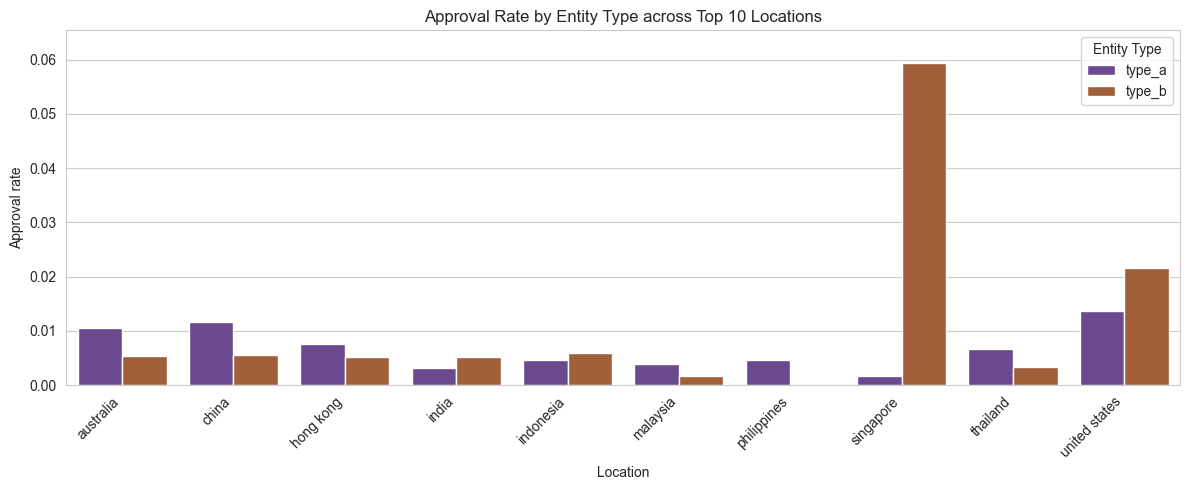

In [32]:
#approval rate by location & entity_type
top_locs = train.location.value_counts().head(10).index.tolist()
agg = (
    train[train.location.isin(top_locs)]
    .groupby(["location","entity_type"])["claim_status"]
    .mean()
    .reset_index())

plt.figure(figsize=(12,5))
sns.barplot(
    x="location", y="claim_status", hue="entity_type",
    data=agg, palette=["#6a3d9a","#b15928"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Approval rate")
plt.xlabel("Location")
plt.title("Approval Rate by Entity Type across Top 10 Locations")
plt.ylim(0, agg.claim_status.max()*1.1)
plt.legend(title="Entity Type")
plt.tight_layout()
plt.show()

Since Singapore is market nominator, it is not too difficult to spot out that claims get the most approved in Singapor, way higher than the other locations.

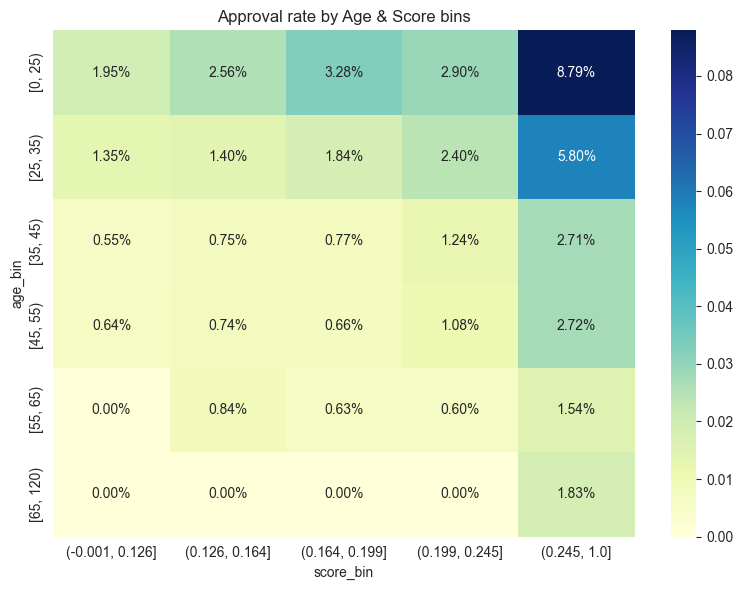

In [33]:
train['age_bin'] = pd.cut(train['person_age'], [0,25,35,45,55,65,120], right=False)
train['score_bin'] = pd.qcut(train['customer_score'], 5)
top_bin = train['score_bin'].max()
pivot_ar = train.pivot_table(index='age_bin', columns='score_bin', values=target, aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_ar, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("Approval rate by Age & Score bins")
plt.tight_layout()
plt.show()

In the top quintile of customer_score (far right column), approval rates jump dramatically, from ~1.8% among seniors (65+) to nearly 8.8% for the youngest (0–25), and settling around 2.7–5.8% for the middle age groups. Within the highest score bin, younger travelers see higher approvals (~8.8% for <25) than older ones (~2.7% for 35–55 and ~1.8% for 65+).

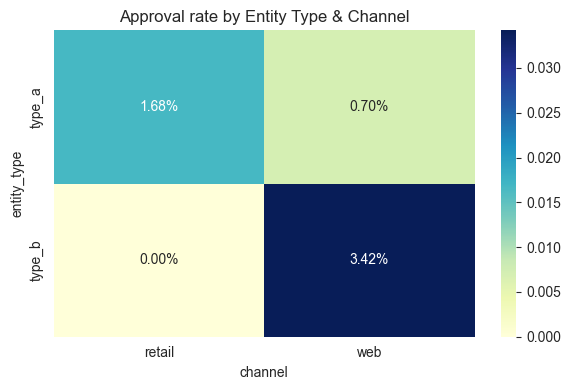

In [34]:
pivot_ec = train.pivot_table(index='entity_type', columns='channel',
                          values=target, aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot_ec, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("Approval rate by Entity Type & Channel")
plt.tight_layout()
plt.show()

Type b almost never approves retail sales but has the highest online approval. Type_a flips that: better in-person, weaker online.

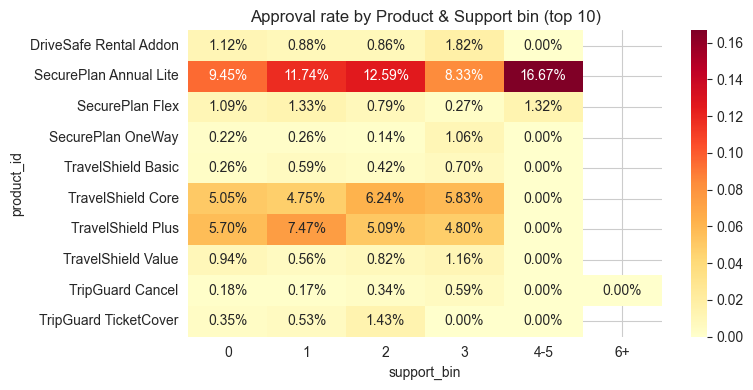

In [35]:
train['support_bin'] = pd.cut(train['support_interactions'],
                           bins=[-1,0,1,2,3,5,train['support_interactions'].max()],
                           labels=['0','1','2','3','4-5','6+'])
top10 = train['product_id'].value_counts().head(10).index
pivot_ps = train[train['product_id'].isin(top10)]\
            .pivot_table(index='product_id', columns='support_bin',
                         values=target, aggfunc='mean')
plt.figure(figsize=(8,4))
sns.heatmap(pivot_ps, annot=True, fmt=".2%", cmap="YlOrRd")
plt.title("Approval rate by Product & Support bin (top 10)")
plt.tight_layout()
plt.show()

Certain products carry inherently high/low claim odds

- SecurePlan Annual Lite has 10–16 % approval regardless of support interactions.
- TripGuard Cancel is essentially never approved (~0 %) and always yields zero commission.

Gender×Entity χ² p-value: 3.66e-155


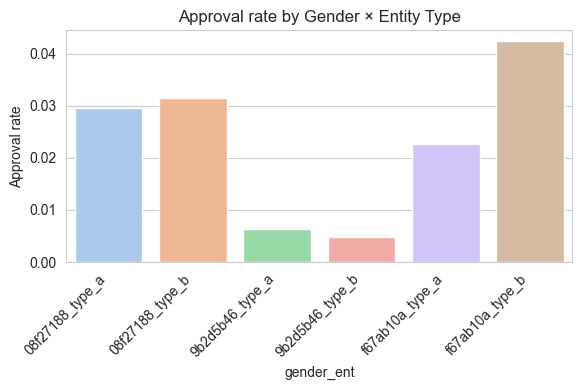

In [36]:
train['gender_ent'] = train['person_gender'] + '_' + train['entity_type']
combo = pd.crosstab(train['gender_ent'], train['claim_status'])
combo['rate'] = combo[1] / combo.sum(axis=1)

chi2, p, *_ = chi2_contingency(combo[[0,1]])
print(f"Gender×Entity χ² p-value: {p:.2e}")

plt.figure(figsize=(6,4))
sns.barplot(x=combo.index, y=combo['rate'], palette="pastel")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Approval rate")
plt.title("Approval rate by Gender × Entity Type")
plt.tight_layout()
plt.show()

We can guess that if client identified themselves as male/female, the probability of getting claim approval is higher than those who left gender unknown. Between type a and b, type b has higher chance of positive claim status. 

# II. Feature Engineering

During this part, we will define new features from the finding above that allow higher confidence of prediction than the existing features.

In [37]:
#frequency encode for location since there are just to many of them
freq = train['location'].value_counts() / len(train)
train['location_freq'] = train['location'].map(freq)

In [38]:
#remove the binning columns (from above analysis)
keep_cols = ['reward', 'claim_status', 'person_gender', 'entity_type', 'channel',
    'support_interactions', 'agent_id', 'customer_score', 'entity_a',
    'person_age', 'revenue', 'product_id', 'trip_length',
    'continent', 'location', 'location_freq']

train = train[keep_cols]

In [39]:
train_no_target = train.drop(columns=['claim_status'])
all_data = pd.concat([train_no_target, test], ignore_index=True)
claim_status = train["claim_status"]

In order to keep everything in hand, we will combine all the new features in one single place.

In [40]:
all_data["reward_margin"]= np.where(all_data["revenue"] != 0, all_data["reward"] / all_data["revenue"],0.0)
all_data["is_discounted"]= (all_data["revenue"] < 0).astype(int)
all_data["high_reward"] = (all_data["reward"] >= all_data["reward"].quantile(0.90)).astype(int)
all_data["long_trip"] = (all_data["trip_length"] > 365).astype(int)
all_data["age_x_score"] = all_data['person_age'] * all_data['customer_score']
all_data["is_SG"] = (all_data['location'] == "singapore").astype(int)
all_data["annual_plan"] = (all_data['product_id'].str.contains('Annual|SecurePlan Family', case=False, na=False)).astype(int)
all_data["agent_annual"] = all_data["agent_id"].isin([5, 13, 14, 8, 1]).astype(int)

all_data = all_data.drop(columns=['location'])
test_final = all_data.iloc[len(train):]
train_final = all_data.iloc[:len(train)]
train_final['claim_status'] = claim_status

approved = train_final[train_final['claim_status']==1]
not_approved = train_final[train_final['claim_status']==0]

***Reward Margin***

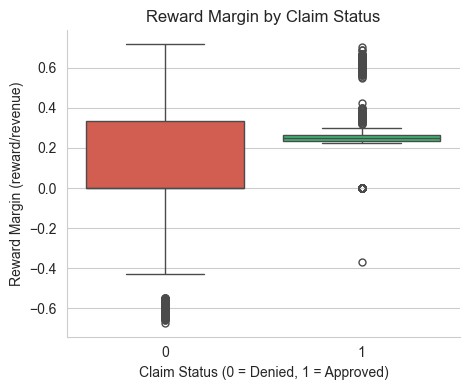

In [41]:
sns.catplot(
    x="claim_status",
    y="reward_margin",
    data=train_final,
    kind="box",
    height=4,
    aspect=1.2,
    palette=["#e74c3c", "#2ecc71"])
plt.xlabel("Claim Status (0 = Denied, 1 = Approved)")
plt.ylabel("Reward Margin (reward/revenue)")
plt.title("Reward Margin by Claim Status")
plt.tight_layout()
plt.show()

There is substantial overlap between the two groups, but the shift toward higher, more consistent margins for approved claims confirms that reward-to-revenue ratio carries signal for claim likelihood, especially at the extremes (very low or negative margins almost never survive, while moderately high margins appear more frequently among approvals).

***Discounted insurance***

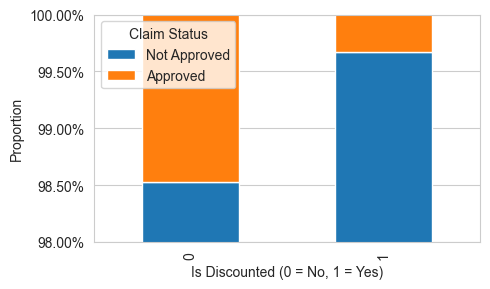

In [42]:
import matplotlib.ticker as mtick
ct = pd.crosstab(train_final['is_discounted'], train_final['claim_status'])
pct = ct.div(ct.sum(axis=1), axis=0)
ax = pct.plot(kind='bar',stacked=True, figsize=(5,3))

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0.98, 1.00)    
ax.set_xlabel('Is Discounted (0 = No, 1 = Yes)')
ax.set_ylabel('Proportion')
ax.legend(['Not Approved','Approved'], title='Claim Status', loc='upper left')

plt.tight_layout()
plt.show()

It is significant to note that those insurance with discount are likely to get claim rejected with the differences up to 2%. 

***Annual trip***

claim_status      0    1
long_trip               
0             54978  706
1              1181  128


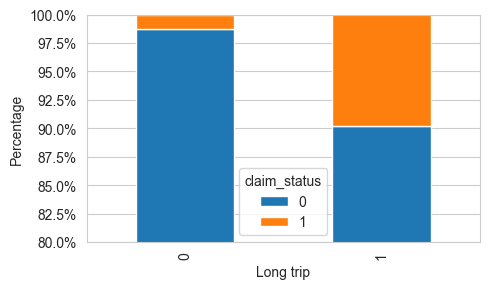

In [43]:
tab = pd.crosstab(train_final['long_trip'], train_final['claim_status'])
print(tab)
ax = tab.div(tab.sum(1).astype(float), axis=0) \
    .plot(kind="bar", stacked=True, figsize=(5,3))

ax.set_ylim(0.8, 1.00)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('Long trip')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

We got the idea that **annual plan insurance receive relatively higher claim approval** compare to those for short term, under 1 year or just a few days/months. 

***High Reward Interaction***

claim_status      0    1
high_reward             
0             50719  579
1              5440  255


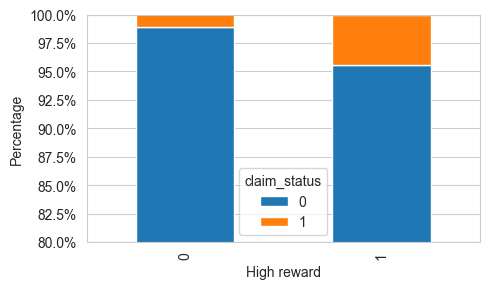

In [44]:
tab = pd.crosstab(train_final['high_reward'], train_final['claim_status'])
print(tab)
ax = tab.div(tab.sum(1).astype(float), axis=0) \
        .plot(kind="bar", stacked=True, figsize=(5,3))

ax.set_ylim(0.8, 1.00)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('High reward')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

Policies that generate larger commissions are about ***5 times more*** likely to have their claims approved than smaller-reward policies. This strong uplift confirms that reward size carries meaningful predictive signal for claim outcomes and justifies including a high_reward flag in the model.

***Age and Score***

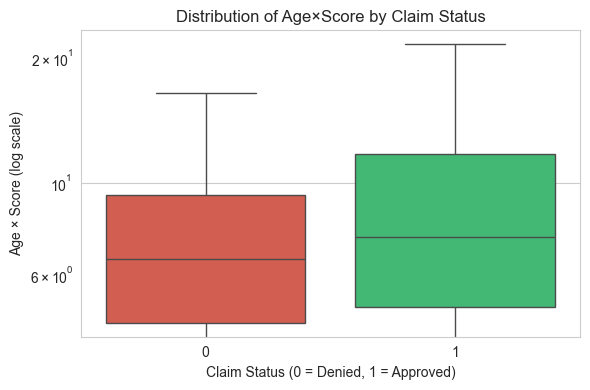

In [45]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x=target,
    y="age_x_score",
    data=train_final,
    palette=["#e74c3c","#2ecc71"],
    showfliers=False)

plt.yscale("log")
plt.xlabel("Claim Status (0 = Denied, 1 = Approved)")
plt.ylabel("Age × Score (log scale)")
plt.title("Distribution of Age×Score by Claim Status")
plt.tight_layout()
plt.show()

In [46]:
rho, p_spear = spearmanr(train_final['claim_status'], train_final["age_x_score"])
print(f"Statistic: {rho}, p-value: {p_spear}")

Statistic: 0.02439714522651997, p-value: 5.707153108325039e-09


The variable age alone does not bring a lot of meaning full prediction since they are overlapping. However, if consider both age and score, there is a significant effect that the higher the value, the more chance its claims would be approved.

***Singapore location***

claim_status      0    1
is_SG                   
0             44723  328
1             11436  506


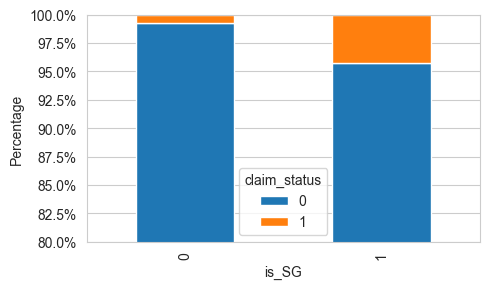

In [47]:
tab = pd.crosstab(train_final['is_SG'], train_final['claim_status'])
print(tab)
ax = tab.div(tab.sum(1).astype(float), axis=0) \
        .plot(kind="bar", stacked=True, figsize=(5,3))

ax.set_ylim(0.8, 1.00)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('is_SG')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

Year-long policies behave very differently in underwriting and claims processing: annual plans carry a much higher claim frequency (and thus a higher approval probability), so treating them as a distinct risk tier (via a long_trip365 flag or an annual_plan category) will materially boost your model’s ability to discriminate.

**Long term insurance package**

claim_status      0    1
annual_plan             
0             54655  656
1              1504  178


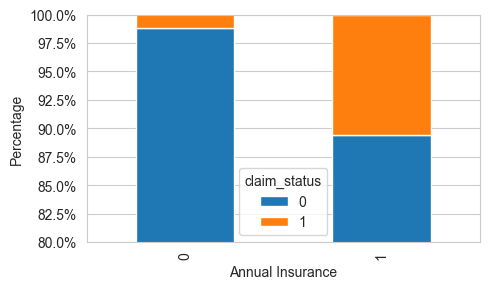

In [48]:
tab = pd.crosstab(train_final['annual_plan'], train_final['claim_status'])
print(tab)
ax = tab.div(tab.sum(1).astype(float), axis=0) \
        .plot(kind="bar", stacked=True, figsize=(5,3))

ax.set_ylim(0.8, 1.00)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('Annual Insurance')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

Annual policies (Annual = 1) show a dramatic shift: roughly 11 % of claims get approved, meaning nearly one in nine. In reverse, only about 1.5 % of claims are approved. 

# III. Model Preparation

Final check up all the variables, take an overview on the correlation matrix between all features, including both old and new one

**train**: original dataset <br>
**train_final**: new dataset with new derived features

## 1. Features selection

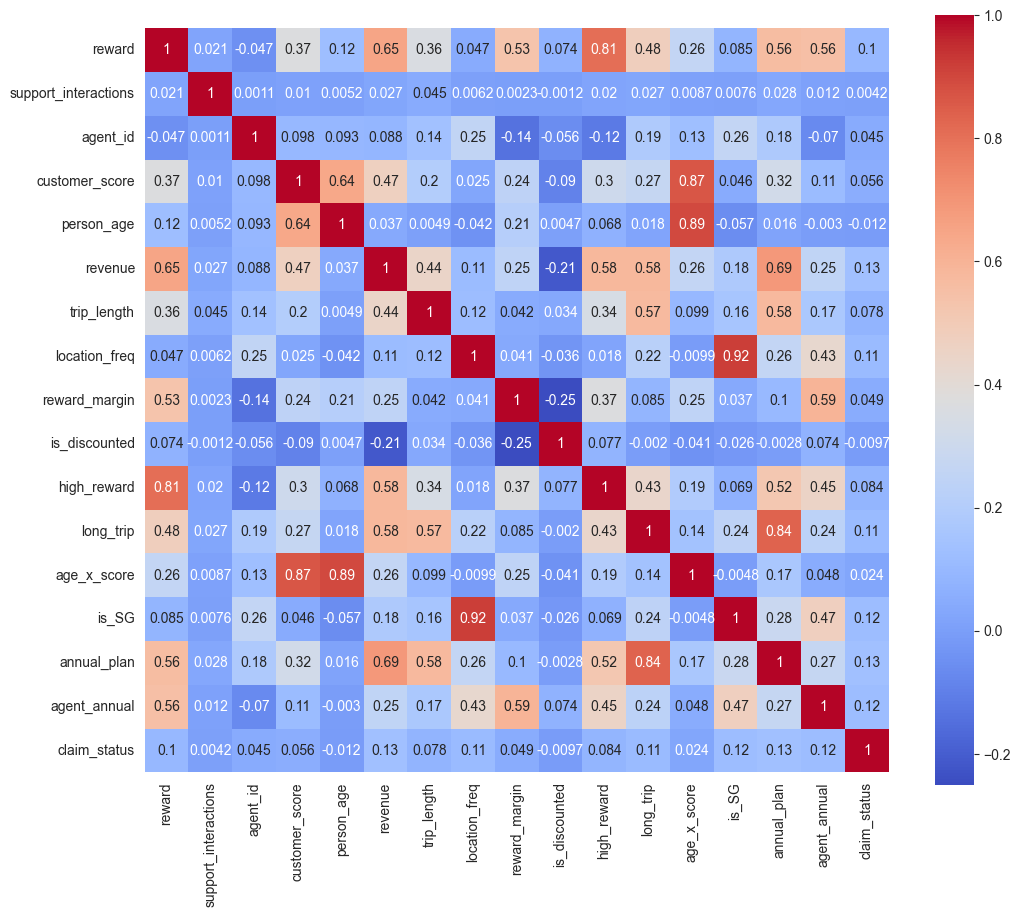

In [49]:
ax = plt.subplots( figsize =( 12 , 10 ) )
foo = sns.heatmap(train_final[train_final.select_dtypes(include=['number']).columns].corr(), vmax=1.0, square=True,
    cmap="coolwarm", annot=True)

**Features summarization:**
- Revenue, reward and trip length are the main factors that drive claim status

- Additional important factors come from:
    - Location: Singapore, US vs other countries
    - Product type: Annual plan vs short term plan
    - Agent in charge
    - Entity type


From the above part, we have computed several extra features which behave similarly with other existing features. For instance, *annual plan* was designed to trip length that is longer than 1 year, so it highly related to *trip length*. There are also other features that correlate with each other and can be seen on the correlation heat map above. 

For now, we have total 22 columns represent for 22 features, including 6 categorical and 16 numerical features. We will try different method to weight feature importance, using Wrapper method and statistical analysis. 

In [50]:
train_final.columns

Index(['reward', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'revenue', 'product_id', 'trip_length', 'continent',
       'location_freq', 'reward_margin', 'is_discounted', 'high_reward',
       'long_trip', 'age_x_score', 'is_SG', 'annual_plan', 'agent_annual',
       'claim_status'],
      dtype='object')

In [51]:
df   = train_final.copy()              
y    = df.pop("claim_status")
X_tr, X_val, y_tr, y_val = train_test_split(
    df, y, test_size=0.20, stratify=y, random_state=42)

In [52]:
cat_cols = ['person_gender','entity_type','channel',
            'entity_a','product_id','continent']
num_cols = [c for c in X_tr.columns if c not in cat_cols]

### 1.1 Statistical tests

**Numerical**

These variables below are highly correlated, therefore, we will be using ANOVA to check the significant of features and decide which one to keep and which one to be removed. 

reward - high reward 
customer score - age x score
person age - age x score
location frequency - is Singapore
annual plan - long trip 

At first, we are using Varianace Threshold to drop any column whose variance is smaller than 0.01

In [53]:
vt = VarianceThreshold(threshold=0.01)
vt.fit(X_tr[num_cols])
num_keep = X_tr[num_cols].columns[vt.get_support()]
print(num_keep)

Index(['reward', 'support_interactions', 'agent_id', 'person_age', 'revenue',
       'trip_length', 'reward_margin', 'is_discounted', 'high_reward',
       'long_trip', 'age_x_score', 'is_SG', 'annual_plan', 'agent_annual'],
      dtype='object')


We ended up with 14 numerical columns after filtering by threshold.

In [54]:
anova = SelectKBest(f_classif, k = 10)
anova.fit(X_tr[num_keep], y_tr)
#num_final = num_keep[anova.get_support()]

SelectKBest()

In [55]:
anova_table = pd.DataFrame({
    "feature" : num_keep,                    # all tested columns
    "F"       : anova.scores_,               # F-statistic
    "p_value" : anova.pvalues_               # p-value
}).sort_values("p_value")

print("\nANOVA results (sorted by p):")
anova_ranked = anova_table.sort_values('F', ascending=False)
print(anova_ranked[['feature','F','p_value']].head(20)) 


ANOVA results (sorted by p):
                 feature           F        p_value
12           annual_plan  739.782085  1.312275e-161
4                revenue  724.590408  2.339578e-158
11                 is_SG  638.879795  5.415258e-140
13          agent_annual  615.457991  5.735350e-135
9              long_trip  474.330669  1.252405e-104
0                 reward  369.255608   5.740953e-82
8            high_reward  288.956987   1.327986e-64
5            trip_length  254.678648   3.544749e-57
6          reward_margin  104.335104   1.815332e-24
2               agent_id   76.502209   2.273217e-18
10           age_x_score   18.794222   1.459193e-05
3             person_age    7.445840   6.360759e-03
7          is_discounted    3.573078   5.872970e-02
1   support_interactions    0.644804   4.219806e-01


In [56]:
sig = anova_table.query("p_value < 0.05").copy()        
sig_sorted = sig.sort_values("F", ascending=False)

print(f"Features retained at α = 0.05 (sorted by F-statistic):\n")
for feat, F in zip(sig_sorted["feature"], sig_sorted["F"]):
    print(f" • {feat:<20s}")

Features retained at α = 0.05 (sorted by F-statistic):

 • annual_plan         
 • revenue             
 • is_SG               
 • agent_annual        
 • long_trip           
 • reward              
 • high_reward         
 • trip_length         
 • reward_margin       
 • agent_id            
 • age_x_score         
 • person_age          


Because several features are highly collinear, we discard long_trip, person_age, and high_reward; each is overshadowed by a correlated variable with a stronger (lower-p) ANOVA signal.

**Categorical features**

In [57]:
enc_tmp   = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_cat_ord = enc_tmp.fit_transform(X_tr[cat_cols]) +1

chi = SelectKBest(score_func=chi2_stat)
chi.fit(X_cat_ord, y_tr)

chi2_vals = pd.Series(chi.scores_, index=cat_cols, name="chi2")
p_vals    = pd.Series(chi.pvalues_, index=cat_cols, name="p")

chi_df = pd.concat([chi2_vals, p_vals], axis=1) \
            .sort_values("chi2", ascending=False)

print("Full χ² table:")
print(chi_df.to_string())

Full χ² table:
                     chi2             p
entity_a       339.156910  9.738255e-76
product_id     188.190533  7.894202e-43
entity_type     70.579423  4.421045e-17
person_gender    2.266527  1.321959e-01
continent        0.564388  4.524977e-01
channel          0.000139  9.905994e-01


From the above table, entity_a, produc_id and entity_type bring significant effect on the claim status, so we will keep them and remove the other 3. 

At this stage, we finalized the total of 12 features, including **annual_plan, revenue, is_SG, agent_annual, reward, trip_length, reward_margin, agent_id, age_x_score, entity_a, product_id, entity_type**       

### 1.2 Wrapper method (LogisticRegression)

In [58]:
cols_reduced = list(num_cols) + list(cat_cols)

enc_ord = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_rfe    = X_tr[cols_reduced].copy()
X_rfe[cat_cols] = enc_ord.fit_transform(X_rfe[cat_cols])

In [59]:
base_lr = LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=1000
)
rfe = RFE(base_lr, n_features_to_select=15, step=1)
rfe.fit(X_rfe.values, y_tr)  

RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000,
                                 solver='liblinear'),
    n_features_to_select=15)

In [60]:
wrap_set = [c for c, keep in zip(cols_reduced, rfe.get_support()) if keep]
print("Wrapper-selected columns:", wrap_set)

Wrapper-selected columns: ['support_interactions', 'agent_id', 'customer_score', 'location_freq', 'reward_margin', 'is_discounted', 'high_reward', 'long_trip', 'is_SG', 'agent_annual', 'person_gender', 'entity_type', 'entity_a', 'product_id', 'continent']


After considering both methods and our knowledge of data, we decide to keep all of those features from the statistical test, with extra features regarding gender and the continent.

### 1.3 LASSO

In [61]:
keep_cols = ['annual_plan', 'revenue', 'is_SG', 'agent_annual', 'reward',
    'trip_length', 'reward_margin', 'agent_id', 'age_x_score',
    'entity_a', 'product_id', 'entity_type', 'person_gender',
    'continent', 'claim_status']

## 2. Splitting the train sample into two sub-samples

In [62]:
train_final = train_final[keep_cols]

In [63]:
train_set, test_set = train_test_split(
    train_final, test_size=0.2, random_state=0, stratify=train_final["claim_status"])
print(f"Total sample size = {train_final.shape[0]}; "
      f"training = {train_set.shape[0]}, testing = {test_set.shape[0]}")

Total sample size = 56993; training = 45594, testing = 11399


## 3. Encode categorical features for both train and test set

In [64]:
obj_cols = train_final.select_dtypes(include=['object']).columns.tolist()
print("Object columns to encode:", obj_cols)

train_enc = pd.get_dummies(train_set, columns=obj_cols, drop_first=True)
test_enc  = pd.get_dummies(test_set,  columns=obj_cols, drop_first=True)

train_enc, test_enc = train_enc.align(test_enc, join='outer', axis=1, fill_value=0)

X_train = train_enc.drop(columns=['claim_status'])
y_train = train_enc['claim_status']
X_test  = test_enc.drop(columns=['claim_status'])
y_test  = test_enc ['claim_status']

Object columns to encode: ['entity_a', 'product_id', 'entity_type', 'person_gender', 'continent']


# IV. Class imbalance

From the finding aboved, we are aware of the target imbalance issue, with only 2% of positive outcome. In this part, diferent class balancing method will be apply in order to compare the models performance.

## 1. Undersampling

In [75]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

## 2. Oversampling

In [82]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_over, y_train_over = rus.fit_resample(X_train, y_train)

## 3. SMOTE

# V. Modelling

## 1. Models with imbalance data

Before settling on a final predictor, we’ll benchmark a broad selection of algorithms.  Starting with Logistic Regression, we’ll run each model through 5-fold stratified cross-validation and record balanced-accuracy (along with precision, recall, F1 and ROC-AUC).  The best-performing model on these CV scores will then be refit on the full training data and evaluated on the test set.

In [92]:
models = [
    ("LogReg",  LogisticRegression(max_iter=1000)),
    ("SVM",     SVC(kernel="rbf", probability=True)),
    ("KNN",     KNeighborsClassifier(n_neighbors=15)),
    ("DecTree", DecisionTreeClassifier(random_state=42)),
    ("RF",      RandomForestClassifier(n_estimators=300, random_state=42)),
    ("XGB",     XGBClassifier(use_label_encoder=False, eval_metric="logloss",scale_pos_weight=1, random_state=42))]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rows = []

def print_metrics(name, y_true, y_pred, y_prob):
    ba  = balanced_accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{name} — metrics")
    print(f"Balanced Acc: {ba:.3f} | Precision: {pre:.3f} | "
          f"Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
    print("-" * 45)

In [ ]:
for name, base_clf in models:
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf",   base_clf)])

    y_pred_cv = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    y_prob_cv = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba")[:, 1]

    print_metrics(name, y_train, y_pred_cv, y_prob_cv)


LogReg — metrics
Balanced Acc: 0.500 | Precision: 0.000 | Recall: 0.000 | F1: 0.000 | ROC-AUC: 0.810
---------------------------------------------


In [100]:
print(classification_report(y_train, y_pred_cv, digits=3))

              precision    recall  f1-score   support

           0      0.985     1.000     0.992     44927
           1      0.083     0.003     0.006       667

    accuracy                          0.985     45594
   macro avg      0.534     0.501     0.499     45594
weighted avg      0.972     0.985     0.978     45594



In [98]:
summary = (pd.DataFrame(rows)
           .sort_values("Balanced Acc", ascending=False)
           .round(3)
           .reset_index(drop=True))
print("\n Cross-validated metrics on under-sampled set")
print(summary.to_string(index=False))

KeyError: 'Balanced Acc'

In [65]:
pipe = Pipeline([("clf",LogisticRegression(max_iter=1000, class_weight='balanced'))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv  = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict')
y_prob_cv  = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

print("Logistic Regression")
print("Balanced accuracy:", round(balanced_accuracy_score(y_train, y_pred_cv), 3))
print("Precision        :", round(precision_score(y_train, y_pred_cv), 3))
print("Recall           :", round(recall_score(y_train, y_pred_cv), 3))
print("F1               :", round(f1_score(y_train, y_pred_cv), 3))
print("ROC-AUC          :", round(roc_auc_score(y_train, y_prob_cv), 3))

pipe.fit(X_train, y_train)
y_pred_test = pipe.predict(X_test)
y_prob_test = pipe.predict_proba(X_test)[:, 1]

print("\nFinal report")
print(classification_report(y_test, y_pred_test, digits=3))

Logistic Regression
Balanced accuracy: 0.746
Precision        : 0.052
Recall           : 0.676
F1               : 0.096
ROC-AUC          : 0.811

Final report
              precision    recall  f1-score   support

           0      0.995     0.818     0.898     11232
           1      0.057     0.737     0.106       167

    accuracy                          0.817     11399
   macro avg      0.526     0.777     0.502     11399
weighted avg      0.981     0.817     0.887     11399



## 2. Models with under sampling

In [106]:
for name, base_clf in models:
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf",   base_clf)])

    y_pred_ud = cross_val_predict(pipe, X_train_under, y_train_under, cv=cv, method="predict")
    y_prob_ud = cross_val_predict(pipe, X_train_under, y_train_under, cv=cv, method="predict_proba")[:, 1]

    print_metrics(name, y_train_under, y_pred_ud, y_prob_ud)


LogReg — metrics
Balanced Acc: 0.749 | Precision: 0.792 | Recall: 0.675 | F1: 0.729 | ROC-AUC: 0.812
---------------------------------------------

SVM — metrics
Balanced Acc: 0.748 | Precision: 0.800 | Recall: 0.661 | F1: 0.724 | ROC-AUC: 0.788
---------------------------------------------

KNN — metrics
Balanced Acc: 0.741 | Precision: 0.748 | Recall: 0.726 | F1: 0.737 | ROC-AUC: 0.811
---------------------------------------------

DecTree — metrics
Balanced Acc: 0.687 | Precision: 0.679 | Recall: 0.712 | F1: 0.695 | ROC-AUC: 0.687
---------------------------------------------

RF — metrics
Balanced Acc: 0.756 | Precision: 0.759 | Recall: 0.750 | F1: 0.754 | ROC-AUC: 0.822
---------------------------------------------

XGB — metrics
Balanced Acc: 0.735 | Precision: 0.735 | Recall: 0.733 | F1: 0.734 | ROC-AUC: 0.797
---------------------------------------------


In [108]:
for name, base_clf in models:
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf", base_clf)])

    y_pred_ov = cross_val_predict(pipe, X_train_over, y_train_over, cv=cv, method="predict")
    y_prob_ov = cross_val_predict(pipe, X_train_over, y_train_over, cv=cv, method="predict_proba")[:, 1]

    print_metrics(name, y_train_over, y_pred_ov, y_prob_ov)


LogReg — metrics
Balanced Acc: 0.749 | Precision: 0.792 | Recall: 0.675 | F1: 0.729 | ROC-AUC: 0.812
---------------------------------------------

SVM — metrics
Balanced Acc: 0.748 | Precision: 0.800 | Recall: 0.661 | F1: 0.724 | ROC-AUC: 0.791
---------------------------------------------

KNN — metrics
Balanced Acc: 0.741 | Precision: 0.748 | Recall: 0.726 | F1: 0.737 | ROC-AUC: 0.811
---------------------------------------------

DecTree — metrics
Balanced Acc: 0.687 | Precision: 0.679 | Recall: 0.712 | F1: 0.695 | ROC-AUC: 0.687
---------------------------------------------

RF — metrics
Balanced Acc: 0.756 | Precision: 0.759 | Recall: 0.750 | F1: 0.754 | ROC-AUC: 0.822
---------------------------------------------

XGB — metrics
Balanced Acc: 0.735 | Precision: 0.735 | Recall: 0.733 | F1: 0.734 | ROC-AUC: 0.797
---------------------------------------------


### **Ranking the models**